***This code was tested and made on [Kaggle](https://www.kaggle.com/) using a P100 GPU.***

In [ ]:
# uncomment to install the required dependencies
# ! pip install torch datasets tokenizers huggingface_hub tqdm

In [2]:
# load the dataset

import datasets
from datasets import load_dataset

def f(sample):
    sample['label'] = 0
    return sample

dataset = load_dataset('mrochk/src_ast_cfg').map(f)

train = dataset['train']
test  = dataset['test']
validation = dataset['validation']

dataset

Generating train split:   0%|          | 0/278620 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15566 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15169 [00:00<?, ? examples/s]

Map:   0%|          | 0/278620 [00:00<?, ? examples/s]

Map:   0%|          | 0/15566 [00:00<?, ? examples/s]

Map:   0%|          | 0/15169 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'cfg', 'ast', 'label'],
        num_rows: 278620
    })
    validation: Dataset({
        features: ['src', 'cfg', 'ast', 'label'],
        num_rows: 15566
    })
    test: Dataset({
        features: ['src', 'cfg', 'ast', 'label'],
        num_rows: 15169
    })
})

In [3]:
# now, we want to shuffle the dataset by exchanging
# ASTs randomly between samples: if we performed
# an exchange, we set the label to 1, otherwise 0

import torch
from tqdm import tqdm

def shuffle(dataset, percentage:float=0.5):
    """
    Shuffle dataset by exchanging ASTs.
    """
    asts   = dataset.data['ast'].to_pylist()
    cfgs   = dataset.data['cfg'].to_pylist()
    labels = dataset.data['label'].to_pylist()

    # when we replace an ast we include the correct one
    # to be able to analyze the model's errors later
    asts_correct = ['' for _ in asts]

    # we exchange each ast at most once
    exchanged    = [False for _ in asts]

    length = len(dataset)

    # number of swaps to perform to shuffle the required percentage
    n_swaps = int(length * percentage) // 2

    print(f'Dataset length: {length}.')
    print(f'nPairs to swap: {n_swaps}...')

    n_swapped = 0

    for _ in range(n_swaps):
        # select 2 random rows that have not been exchanged before
        while True:
            
            row1 = torch.randint(low=0, high=length, size=(1,))
            row2 = torch.randint(low=0, high=length, size=(1,))
            
            condition = (not exchanged[row1]) and (not(exchanged[row2]))

            if condition: break
            
        if row1 == row2: continue # rows must be different

        ast1, ast2 = asts[row1], asts[row2]

        if ast1 == ast2: continue # asts must be different
            
        asts_correct[row1], asts_correct[row2] = ast1, ast2

        # performin the exchange
        asts[row1], asts[row2] = ast2, ast1

        # since we modified these rows we set their labels to 1
        labels[row1] = labels[row2] = 1

        # same for the list tracking the exchanged samples
        exchanged[row1] = exchanged[row2] = True

        n_swapped += 1

    print(f'nPairs swapped: {n_swapped}.')

    # building the new dataset
    new_dataset = [{'cfg': cfgs[i], 'ast': asts[i], 'ast_correct': asts_correct[i], 'label':labels[i]} for i in range(length)]

    # converting it to a proper HuggingFace dataset and returning it
    return datasets.Dataset.from_list(new_dataset)

def count_ones(dataset:datasets.dataset_dict.DatasetDict):
    """
    Simple function to verify that a dataset was properly shuffled.
    """
    ones = 0
    for sample in tqdm(dataset):
        if sample['label'] == 1: ones +=1
    return ones

In [4]:
train = shuffle(train, .5); print()
test = shuffle(test, .5); print()
validation = shuffle(validation, .5)

ones_train = count_ones(train)
ones_test  = count_ones(test)
ones_val   = count_ones(validation)

print(f'Train: {ones_train * 100 / len(train):.0f}%.')
print(f'Test: {ones_test * 100 / len(test):.0f}%.')
print(f'Validation: {ones_val * 100 / len(validation):.0f}%.')

Dataset length: 278620.
nPairs to swap: 69655...
nPairs swapped: 69655.

Dataset length: 15169.
nPairs to swap: 3792...
nPairs swapped: 3792.

Dataset length: 15566.
nPairs to swap: 3891...
nPairs swapped: 3890.


100%|██████████| 15566/15566 [00:00<00:00, 17353.78it/s]

Train: 50%.
Test: 50%.
Validation: 50%.


In [5]:
from tokenizers import Tokenizer

tokenizer_cfg = Tokenizer.from_file(
    '/kaggle/input/tokenizer-cfg-2000/tokenizer_cfg_2000.json'
)

tokenizer_ast = Tokenizer.from_file(
    '/kaggle/input/tokenizer-ast-2000/tokenizer_ast_2000.json'
)

ast = train[0]['ast']
cfg = train[0]['cfg']

tokenizer_cfg_vocabsize = tokenizer_cfg.get_vocab_size()
tokenizer_ast_vocabsize = tokenizer_ast.get_vocab_size()

print(f'Vocabsize tokenizer CFG: {tokenizer_cfg_vocabsize}.')
print(f'Vocabsize tokenizer AST: {tokenizer_ast_vocabsize}.')

print(tokenizer_ast.encode(ast).tokens)
print(tokenizer_cfg.encode(cfg).tokens)

Vocabsize tokenizer CFG: 2000.
Vocabsize tokenizer AST: 2000.
['MODULE_FUNCTIONDEF_ARGUMENTS_ARG_ARG_EXPR_CONSTANT_ASSIGN_NAME_STORE_', 'CALL_NAME_LOAD_NAME_LOAD_ATTRIBUTE_NAME_LOAD_LOAD_', 'EXPR_CALL_ATTRIBUTE_NAME_LOAD_LOAD_ATTRIBUTE_NAME_LOAD_LOAD_', 'NAME_LOAD']
['[2]', '[SEP1]', '[Return]', '[SEP2]', '[]', '[SEP3]', '[5]']


In [13]:
# before creating the dataset, we need to know what sequence lengths to set

len_cfgs, len_asts = [], []

for sample in tqdm(train):
    len_cfg = len(tokenizer_cfg.encode(sample['cfg']).ids)
    len_ast = len(tokenizer_ast.encode(sample['ast']).ids)

    len_cfgs.append(len_cfg)
    len_asts.append(len_ast)

len_cfgs = torch.tensor(len_cfgs, dtype=torch.float)
len_asts = torch.tensor(len_asts, dtype=torch.float)

mean_cfg = len_cfgs.mean()
std_cfg  = len_cfgs.std()

mean_ast = len_asts.mean()
std_ast  = len_asts.std()

print(f'Average CFG length: {mean_cfg:.2f}, mean + 2std = {mean_cfg + 2*std_cfg:.2f}.')
print(f'Average AST length: {mean_ast:.2f}, mean + 2std = {mean_ast + 2*std_ast:.2f}.')

100%|██████████| 278620/278620 [01:35<00:00, 2920.33it/s]


Average CFG length: 10.52; Mean + 2*stdev: 27.94.
Average AST length: 16.33; Mean + 2*stdev: 55.03.


In [14]:
# it seems like 30 and 60 are good thresholds for our seq_lengths, 
# let's verify that most values fall inside these ranges

seq_len_cfg = 30
seq_len_ast = 60

count_ast = count_cfg = 0
for sample in tqdm(train):
    
    len_cfg = len(tokenizer_cfg.encode(sample['cfg']))
    if len_cfg <= seq_len_cfg: count_cfg += 1

    len_ast = len(tokenizer_ast.encode(sample['ast']).ids)
    if len_ast <= seq_len_ast: count_ast += 1

print(f'Percentage of asts s.t ast <= {seq_len_ast}: {int(count_ast * 100 / len(train))}%.')
print(f'Percentage of cfgs s.t src <= {seq_len_cfg}: {int(count_cfg * 100 / len(train))}%.')

100%|██████████| 278620/278620 [01:33<00:00, 2967.86it/s]

Percentage of asts s.t ast <= 60: 97%.
Percentage of cfgs s.t src <= 30: 97%.


In [15]:
# we can now create the pytorch datasets

from torch.utils.data import Dataset, DataLoader

class CFG_AST_Dataset(Dataset):
    def __init__(
        self, 
        split, # the huggingface dataset split
        tokenizer_cfg=tokenizer_cfg,
        tokenizer_ast=tokenizer_ast,
        seq_len_cfg=seq_len_cfg,
        seq_len_ast=seq_len_ast,
    ):
        
        self.dataset = split

        self.seq_len_cfg = seq_len_cfg
        self.seq_len_ast = seq_len_ast

        self.tokenizer_cfg = tokenizer_cfg
        self.tokenizer_ast = tokenizer_ast

        self.cls_token_cfg = tokenizer_cfg.token_to_id('[CLS]')
        self.cls_token_ast = tokenizer_ast.token_to_id('[CLS]')

        self.pad_token_cfg = tokenizer_cfg.token_to_id('[PAD]')
        self.pad_token_ast = tokenizer_ast.token_to_id('[PAD]')

    def __len__(self): return len(self.dataset)

    def __getitem__(self, index):
        row = self.dataset[index]
        cfg, ast, label = row['cfg'], row['ast'], row['label']

        input_tokens_cfg = [self.cls_token_cfg] + self.tokenizer_cfg.encode(cfg).ids
        input_tokens_ast = [self.cls_token_ast] + self.tokenizer_ast.encode(ast).ids

        n_pad_tokens_cfg = self.seq_len_cfg - len(input_tokens_cfg)
        n_pad_tokens_ast = self.seq_len_ast - len(input_tokens_ast)
        
        if n_pad_tokens_cfg >= 0: # we add padding tokens if needed
            input_tokens_cfg = input_tokens_cfg + ([self.pad_token_cfg] * n_pad_tokens_cfg)
        else: # the sequence is larger than the max seq length
            input_tokens_cfg = input_tokens_cfg[:self.seq_len_cfg] # we crop it

        if n_pad_tokens_ast >= 0: # we add padding tokens if needed
            input_tokens_ast = input_tokens_ast + ([self.pad_token_ast] * n_pad_tokens_ast)
        else: # the sequence is larger than the max seq length
            input_tokens_ast = input_tokens_ast[:self.seq_len_ast] # we crop it

        return {
            'input_tokens_cfg': torch.tensor(input_tokens_cfg, dtype=torch.int64),
            'input_tokens_ast': torch.tensor(input_tokens_ast, dtype=torch.int64),
            'label': torch.tensor(label, dtype=torch.float).unsqueeze(-1)
        }

In [21]:
ds_train = CFG_AST_Dataset(train, tokenizer_cfg, tokenizer_ast)
ds_test = CFG_AST_Dataset(test, tokenizer_cfg, tokenizer_ast)
ds_validation = CFG_AST_Dataset(validation, tokenizer_cfg, tokenizer_ast)

print(ds_train[0]['input_tokens_cfg'].shape)
print(ds_train[0]['input_tokens_ast'].shape)
print(ds_train[0]['label'].shape)

torch.Size([30])
torch.Size([60])
torch.Size([1])


In [22]:
# the positional encoding as in Attention Is All You Need

from torch import nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int, seq_len:int, dropout:float=0.1):
        super().__init__()

        self.dropout = nn.Dropout(dropout)

        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10_000.0) / d_model))

        pe = torch.zeros(seq_len, d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

In [23]:
# testing

dl = DataLoader(ds_test, batch_size=2)

eg = next(iter(dl))

asts = eg['input_tokens_ast']
print(asts.shape)

emb = nn.Embedding(tokenizer_ast.get_vocab_size(), 4)
emb_asts = emb(asts)

print(emb_asts.shape)

pe = PositionalEncoding(4, 70)
out = pe(emb_asts)
out.shape

torch.Size([2, 60])
torch.Size([2, 60, 4])


torch.Size([2, 60, 4])

In [26]:
# creating the transformer encoder module

class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size:int,  # tokenizer vocab size
        seq_len:int,     # sequence length in our batch
        pad_token:int,   # token used for padding
        nlayers:int=8,   # number of layers
        nheads:int=8,    # number of attention heads
        d_model:int=512, # embedding size for each token & also dimension of output
        d_ff:int=2048,   # ffn hidden layer size
        ):

        super().__init__()

        self.pad_token = pad_token

        self.input_embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model,
        )

        self.positional_encoding = PositionalEncoding(
            d_model=d_model,
            seq_len=seq_len,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nheads,
            dim_feedforward=d_ff,
            batch_first=True,
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=nlayers
        )

    def forward(self, x):

        x = self.input_embedding(x)

        x = self.positional_encoding(x)

        x = self.encoder(x)[:, 0]

        return x

In [27]:
# testing

eg = next(iter(dl))
x = eg['input_tokens_ast']

enc = Encoder(
    vocab_size=len(tokenizer_ast.get_vocab()),
    seq_len=x.shape[1],
    pad_token=tokenizer_ast.token_to_id('[PAD]'),
)

out = enc(x)
out.shape

torch.Size([2, 512])

In [28]:
# now we define the complete architecture of our model

class CfgAstClassifier(nn.Module):
    def __init__(
        self,
        vocab_size_cfg:int=5000,  # vocab size of src tokenizer
        vocab_size_ast:int=5000,  # vocab size of cfg tokenizer
        
        seq_len_cfg:int=seq_len_cfg,     # batch sequence length for src
        seq_len_ast:int=seq_len_ast,     # batch sequence length for cfg
        
        pad_token_cfg:int=tokenizer_cfg.token_to_id('[PAD]'),   # token used to pad src
        pad_token_ast:int=tokenizer_ast.token_to_id('[PAD]'),   # token used to pad cfg
        
        d_model_cfg:int=512, # embedding size for each tokens in ast encoder
        d_model_ast:int=512, # embedding size for each tokens in src encoder
        
        nlayers_cfg:int=8,
        nlayers_ast:int=8,
        
        nheads_cfg:int=8,
        nheads_ast:int=8,
        
        d_ff:int=2048,       # ffn hidden layer size
        
        d_ff_enc:int=2048,   # encoders ffn hidden layer size
        ):

        super().__init__()

        # the encoder used to encode the function source code
        self.encoder_cfg = Encoder(
            vocab_size=vocab_size_cfg,
            seq_len=seq_len_cfg,
            pad_token=pad_token_cfg,
            d_model=d_model_cfg,
            d_ff=d_ff_enc,
            nlayers=nlayers_cfg,
            nheads=nheads_cfg,
        )

        # the encoder used to encode the function cfg
        self.encoder_ast = Encoder(
            vocab_size=vocab_size_ast,
            seq_len=seq_len_ast,
            pad_token=pad_token_ast,
            d_model=d_model_ast,
            d_ff=d_ff_enc,
            nlayers=nlayers_ast,
            nheads=nheads_ast,
        )
        
        # feedforward layer
        self.ffn = nn.Sequential(
            nn.Linear(d_model_ast + d_model_cfg, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, 1)
        )

        # output
        self.logistic = nn.Sigmoid()

    def forward(self, cfg, ast):
        
        out_cfg = self.encoder_cfg(cfg)
        out_ast = self.encoder_ast(ast)

        cat = torch.cat([out_cfg, out_ast], dim=-1)

        ffn = self.ffn(cat)

        out = self.logistic(ffn)

        return out

In [31]:
# testing 

eg = next(iter(dl))

eg_ast = eg['input_tokens_ast']
eg_cfg = eg['input_tokens_cfg']

model = CfgAstClassifier()

model(eg_cfg, eg_ast)

tensor([[0.5407],
        [0.5627]], grad_fn=<SigmoidBackward0>)

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}.')

Using cuda.


In [37]:
# training the model

from sklearn.metrics import accuracy_score

eg = next(iter(dl))
eg_ast = eg['input_tokens_ast']
eg_cfg = eg['input_tokens_cfg']

empty_cache = lambda: torch.cuda.empty_cache() if device == 'cuda' else None
empty_cache()

# instantiating the transformer encoder model
model = CfgAstClassifier().to(device)

# optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

# loss function: binary cross entropy
lossfunc = torch.nn.BCELoss()

# batch size
batch_size = 128

# number of epochs
epochs = 3

dataset = ds_train # dataset to use

# dataset -> dataloader
batchs  = DataLoader(dataset, batch_size=batch_size)
nbatchs = len(batchs)

losses = []
accuracies = []
add_loss = 7 # add loss to 'losses' every 'add_loss' batchs

# training loop
for epoch in range(epochs):
    empty_cache()

    model.train() # set model in training mode

    epoch_loss = 0.0
    loss_plot  = 0.0

    for i, batch in enumerate(tqdm(batchs)):

        # get inputs
        ast    = batch['input_tokens_ast'].to(device)
        cfg    = batch['input_tokens_cfg'].to(device)
        labels = batch['label'].to(device)

        # forward
        optim.zero_grad()

        predictions = model(cfg, ast)

        loss = lossfunc(predictions, labels)

        _loss_ = loss.item()

        loss_plot  += _loss_
        epoch_loss += _loss_

        if (i+1) % add_loss == 0:
            
            # get loss
            losses.append(loss_plot / add_loss)
            loss_plot = 0.0
            
            # get accuracy
            model.eval()
            
            batch  = next(iter(batchs))
            ast    = batch['input_tokens_ast'].to(device)
            cfg    = batch['input_tokens_cfg'].to(device)
            labels = batch['label'].to(device).squeeze().tolist()
            
            predictions = (model(cfg, ast).squeeze() > .5).int().tolist()
            
            accuracy = accuracy_score(labels, predictions)
            accuracies.append(accuracy)
            
            model.train()

        # backward
        loss.backward()
        optim.step()

    # log epoch
    print(f'\nEpoch {epoch+1} / {epochs}, Loss: [{epoch_loss / nbatchs:.2f}].')

    # save model at each epoch
    torch.save(model, f'cfg_to_ast_{epoch+1}.pt'); print('\nModel saved.\n')

print('\nDone.')

100%|██████████| 2177/2177 [12:47<00:00,  2.84it/s]



Epoch 1 / 3, Loss: [0.47].

Model saved.



100%|██████████| 2177/2177 [12:48<00:00,  2.83it/s]



Epoch 2 / 3, Loss: [0.33].

Model saved.



100%|██████████| 2177/2177 [12:49<00:00,  2.83it/s]



Epoch 3 / 3, Loss: [0.26].

Model saved.


Done.


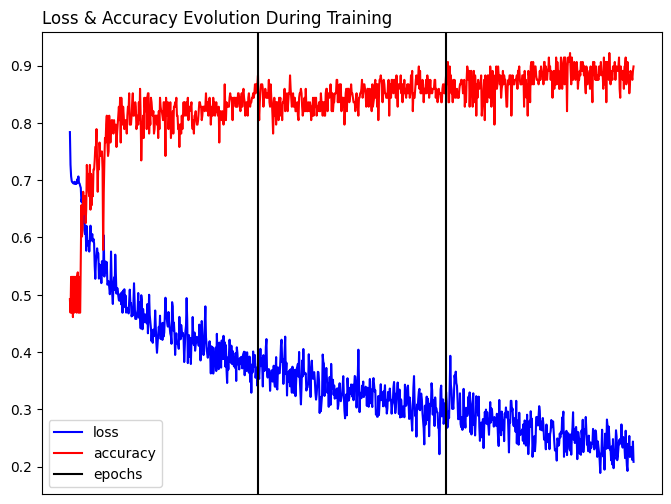

In [38]:
# plotting loss & accuracy

import matplotlib.pyplot as plt

xs_per_epoch = len(losses) // epochs

plt.figure(figsize=(8, 6))

plt.plot(losses, color='blue', label='loss')

plt.plot(accuracies, color='red', label='accuracy')

plt.plot([], color='black', label='epochs')

plt.legend()

plt.title(f'Loss & Accuracy Evolution During Training', loc='left')

plt.xticks([])

for e in range(1, epochs):
    plt.axvline(x=xs_per_epoch*e, color='black')

None

In [40]:
# getting predictions

def predictions(model:nn.Module, dataset:Dataset, batch_size:int=128):
    model.eval()

    labels, preds = [], []
    batchs = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for batch in tqdm(batchs):

        ast    = batch['input_tokens_ast'].to(device)
        cfg    = batch['input_tokens_cfg'].to(device)
        labels += batch['label'].to(device).int().squeeze(1).tolist()
        preds  += [_.item() for _ in (model(cfg, ast).squeeze(1) > 0.5).int()]

    return preds, labels

preds_val,  labels_val  = predictions(model, ds_validation)
preds_test, labels_test = predictions(model, ds_test)

100%|██████████| 119/119 [00:19<00:00,  6.18it/s]


In [44]:
from sklearn.metrics import classification_report 

print(classification_report(labels_val, preds_val))
print(classification_report(labels_test, preds_test))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7786
           1       0.98      0.87      0.92      7780

    accuracy                           0.92     15566
   macro avg       0.93      0.92      0.92     15566
weighted avg       0.93      0.92      0.92     15566

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7585
           1       0.98      0.86      0.92      7584

    accuracy                           0.92     15169
   macro avg       0.93      0.92      0.92     15169
weighted avg       0.93      0.92      0.92     15169

